For a particular model --> for a selected fold -->
- From the top 500 samples in the json: correctly predicted set and incorrectly predicted set
- From the bottom 500 samples in the json: correctly predicted set and incorrectly predicted set

For the obtained 4 sets, plot graphs for average disagreement (lime vs shap, lime vs global, shap vs global) for each compactor.

In [1]:
# Import libraries
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import json
from typing import Union
import numpy as np
from disagreement import Disagreement

In [2]:
from compactor.MaxNonActivatedCompactor import MaxNonActivatedCompactor
from compactor.ActivatedCompactor import ActivatedCompactor
from compactor.MaxCompactor import MaxCompactor

In [3]:
main_path = "/storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/"

baseline_json_file_path =  main_path + "model_outputs_13/xai_results/all_exp.json"
json_file_path = main_path + "model_outputs_6/xai_results/all_exp.json"

model_path = main_path + "model_outputs/artifacts/random_forest_t_300_md_10/" + "random_forest_t_300_md_10_fold_1_2016-01-07.pkl"
predictions_file_path = main_path + "model_outputs/artifacts/random_forest_t_300_md_10/test_prediction_fold_1_2016-01-07.csv"

processed_data_path = main_path + "processed_data/processed_final_data_latest.csv"

fold = 'fold0'

images_save_path = "Images_XAI_Fold_1_2016-01-07/RF_Baseline_6000"

In [4]:
categorical_cols = ["Project Type", "Project Subject Category Tree", "Project Subject Subcategory Tree",
                    "Project Grade Level Category", "Project Resource Category", "School Metro Type",
                    "School State", "Teacher Prefix",
                    ]

In [24]:
!ls /storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/

config.py		   model_outputs_5
data			   model_outputs_6
data_processer.ipynb	   model_outputs_8
data_processor.py	   model_parameters
eda.py			   nohup.out
environment.yml		   processed_data
Feature_Engineering.ipynb  processed_final_data_latest.csv
Feature_Engineering.py	   __pycache__
feature_engineer.py	   README.md
helper.py		   requirements.txt
kernelshap_explainer.py    run_explanations.py
lime_explainer.py	   Sanity_checks.ipynb
main.py			   temporal_features.py
model_outputs		   trained_models
model_outputs_10	   treeshap_explainer.py
model_outputs_13	   Untitled.ipynb
model_outputs_2		   xai_results
model_outputs_3		   xai_test_results
model_outputs_4


In [5]:
# Function to save images
def save_image(caption, path):
    set_path = f'{path}/{caption}.png'
    plt.savefig(set_path)

In [6]:
# Load predictions - To get the predicted label
predictions = pd.read_csv(predictions_file_path)
predictions.head()

,Unnamed: 0,Project ID,1,Start Date
0,54,102f47610669fc10a9742ef95bfe21a8,0.347448,2016-01-07
1,67,918a8b2f88d1016c98506780c92ca2ef,0.352459,2016-01-07
2,73,3b2a53dad2bbfa3a6e8a70a8614f3794,0.425271,2016-01-07
3,98,9efe5e053be0b42ae131de6e128253f4,0.347134,2016-01-07
4,138,964f3a78df08d5e78943f6941982be39,0.280771,2016-01-07


In [7]:
# Read dataframe to get actual label and for the categorical columns
processed = pd.read_csv(processed_data_path)
processed.columns

Index(['Unnamed: 0', 'Project ID', 'Project Posted Date', 'Project Type',
       'Project Posted Month', 'Project Subject Category Tree', 'Project Cost',
       'Project Subject Subcategory Tree', 'Project Grade Level Category',
       'Project Resource Category', 'School Metro Type',
       'School Percentage Free Lunch', 'School State', 'Teacher Prefix',
       'Teacher Project Posted Sequence', 'Label', 'Teacher Success Rate',
       'Teacher Success Rate Imputed', 'School City Success Rate',
       'School City Success Rate Imputed', 'School Success Rate',
       'School Success Rate Imputed', 'School County Success Rate',
       'School County Success Rate Imputed', 'Project Count in State'],
      dtype='object')

In [8]:
# Load explanations
explanations = json.load(open(json_file_path))
explanations_baseline = json.load(open(baseline_json_file_path))


In [9]:
explanations_baseline_combined_exp1 = explanations_baseline[fold]["lime"]["top"] | explanations_baseline[fold]["lime"]["bottom"]
explanations_baseline_combined_exp2 = explanations_baseline[fold]["treeshap"]["top"] | explanations_baseline[fold]["treeshap"]["bottom"]

In [10]:
print(len(explanations_baseline_combined_exp1.keys()))

6000


In [10]:
# For testing
# Check disagreement for a single explanation in top with activated compactor
disagreement = Disagreement(explanations_baseline_combined_exp1['fd88cf9d7d7d0d5f2fd59e8c14f16627'], explanations_baseline_combined_exp2['fd88cf9d7d7d0d5f2fd59e8c14f16627'])

activated_features = {}
for feature in categorical_cols:
    activated_features[feature] = f"{feature}_{processed[processed['Project ID'] == 'fd88cf9d7d7d0d5f2fd59e8c14f16627' ][feature].values[0]}"

activated_compactor = ActivatedCompactor(activated_features)
disagreement.compact_features(activated_compactor)
disagreement.get_disagreement(23, None)

{'feature_agreement': 0.9130434782608695,
 'rank_agreement': 0.21739130434782608,
 'sign_agreement': 0.782608695652174,
 'signed_rank_agreement': 0.17391304347826086}

Calculating the average disagreement

1. LIME vs SHAP

In [11]:
def disagreement_average(explanations_1, explanations_2, both_local, k, features_F, raw_data=None, method=None):
    
    # explanations_1 is always local
    # explanations_2 can either be local or global
    
    disagreement_mean = {'feature_agreement': 0.0,
                         'rank_agreement': 0.0,
                         'sign_agreement': 0.0,
                         'signed_rank_agreement': 0.0
                        }
    disagreement_calc = None

    for project_id in explanations_1.keys():
        # Initialize disagreement calculation
        if both_local:
            disagreement_calc = Disagreement(explanations_1[project_id], explanations_2[project_id])
        else:
            disagreement_calc = Disagreement(explanations_2, explanations_1[project_id])

        # Select compactor
        if method=="max":
            max_compactor = MaxCompactor(categorical_cols)
            disagreement_calc.compact_features(max_compactor)
            
        elif method == "activated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            activated_compactor = ActivatedCompactor(activated_features)
            disagreement_calc.compact_features(activated_compactor)
            
        elif method == "maxnonactivated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            max_non_activated_compactor = MaxNonActivatedCompactor(activated_features)
            disagreement_calc.compact_features(max_non_activated_compactor)

        # Get disagreement
        disagreement_levels = disagreement_calc.get_disagreement(k, features_F)

        for key in list(disagreement_mean.keys()):
            if disagreement_levels[key] == None:
                raise ValueError(f"The value for key '{key}' in disagreement_mean is None.")
            disagreement_mean[key] += disagreement_levels[key]

    for key in list(disagreement_mean.keys()):
        disagreement_mean[key] = round(disagreement_mean[key] / len(explanations_1.keys()),3)

    
    return disagreement_mean

In [12]:
def disagreement_for_exp_dict(exp1, exp2, exp1_baseline, exp2_baseline, k_range, method=None, raw_data=None):

    # Explanation for the top list
    disagreement_mean_across_top = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_top = disagreement_average(exp1["top"], exp2["top"], True, i, None, raw_data, method)

        for key in list(disagreement_mean_across_top.keys()):
            disagreement_mean_across_top[key].append(explanations_top[key])

    # Explanation for the bottom list
    disagreement_mean_across_bottom = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_bottom = disagreement_average(exp1["bottom"], exp2["bottom"], True, i, None, raw_data, method)

        for key in list(disagreement_mean_across_bottom.keys()):
            disagreement_mean_across_bottom[key].append(explanations_bottom[key])

    # Baseline explanations
    disagreement_mean_across_baseline = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_baseline = disagreement_average(exp1_baseline, exp2_baseline, True, i, None, raw_data, method)

        for key in list(disagreement_mean_across_baseline.keys()):
            disagreement_mean_across_baseline[key].append(explanations_baseline[key])
    
    return disagreement_mean_across_top, disagreement_mean_across_bottom, disagreement_mean_across_baseline

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_average_accross_n_projects_various_k_features(disagreement_mean_across_top, disagreement_mean_across_bottom, disagreement_mean_across_baseline, feature_n, caption):

    feature_range = range(1, feature_n+1, 1)

    # Create separate subplots for each agreement metric
    fig, axs = plt.subplots(4, 1, figsize=(10, 16))

    # Plot Feature Agreement for top k
    axs[0].plot(feature_range, disagreement_mean_across_top["feature_agreement"], label='Feature Agreement (Top Projects)', marker='o', color='b')
    axs[0].plot(feature_range, disagreement_mean_across_bottom["feature_agreement"], label='Feature Agreement (Bottom Projects)', linestyle='--', marker='o', color='r')
    axs[0].plot(feature_range, disagreement_mean_across_baseline["feature_agreement"], label='Feature Agreement (Baseline)', marker='o', color='#ee82ee')
    axs[0].set_xlabel('Number of Features (Top K)')
    axs[0].set_ylabel('Agreement Score')
    axs[0].set_title('Feature Agreement vs. Number of Features (Top K)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Rank Agreement for top k
    axs[1].plot(feature_range, disagreement_mean_across_top["rank_agreement"], label='Rank Agreement (Top Projects)', marker='s', color='g')
    axs[1].plot(feature_range, disagreement_mean_across_bottom["rank_agreement"], label='Rank Agreement (Bottom Projects)', linestyle='--', marker='s', color='m')
    axs[1].plot(feature_range, disagreement_mean_across_baseline["rank_agreement"], label='Rank Agreement (Baseline)', marker='s', color='#3cb371')
    axs[1].set_xlabel('Number of Features (Top K)')
    axs[1].set_ylabel('Agreement Score')
    axs[1].set_title('Rank Agreement vs. Number of Features (Top K)')
    axs[1].legend()
    axs[1].grid(True)

    # Plot Sign Agreement for top k
    axs[2].plot(feature_range, disagreement_mean_across_top["sign_agreement"], label='Sign Agreement (Top Projects)', marker='^', color='c')
    axs[2].plot(feature_range, disagreement_mean_across_bottom["sign_agreement"], label='Sign Agreement (Bottom Projects)', linestyle='--', marker='^', color='y')
    axs[2].plot(feature_range, disagreement_mean_across_baseline["sign_agreement"], label='Sign Agreement (Baseline)', marker='^', color='#ff6347')
    axs[2].set_xlabel('Number of Features (Top K)')
    axs[2].set_ylabel('Agreement Score')
    axs[2].set_title('Sign Agreement vs. Number of Features (Top K)')
    axs[2].legend()
    axs[2].grid(True)

    # Plot Signed Rank Agreement for top k
    axs[3].plot(feature_range, disagreement_mean_across_top["signed_rank_agreement"], label='Signed Rank Agreement (Top Projects)', marker='x', color='k')
    axs[3].plot(feature_range, disagreement_mean_across_bottom["signed_rank_agreement"], label='Signed Rank Agreement (Bottom Projects)', linestyle='--', marker='x', color='orange')
    axs[3].plot(feature_range, disagreement_mean_across_baseline["signed_rank_agreement"], label='Signed Rank Agreement (Baseline)', marker='x', color='#463505')
    axs[3].set_xlabel('Number of Features (Top K)')
    axs[3].set_ylabel('Agreement Score')
    axs[3].set_title('Signed Rank Agreement vs. Number of Features (Top K)')
    axs[3].legend()
    axs[3].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    save_image(caption, images_save_path)
    plt.show()

Top 10%

In [22]:
# Top 10% with no compactor
#disagreement_for_exp_dict(exp1, exp2, exp1_baseline, exp2_baseline, k_range, method=None, raw_data=None)
mean_top_lvs_non_10 , mean_bottom_lvs_non_10, mean_base_lvs_non_10 = disagreement_for_exp_dict(explanations[fold]['lime'], explanations[fold]['treeshap'], explanations_baseline_combined_exp1, explanations_baseline_combined_exp2, 58)

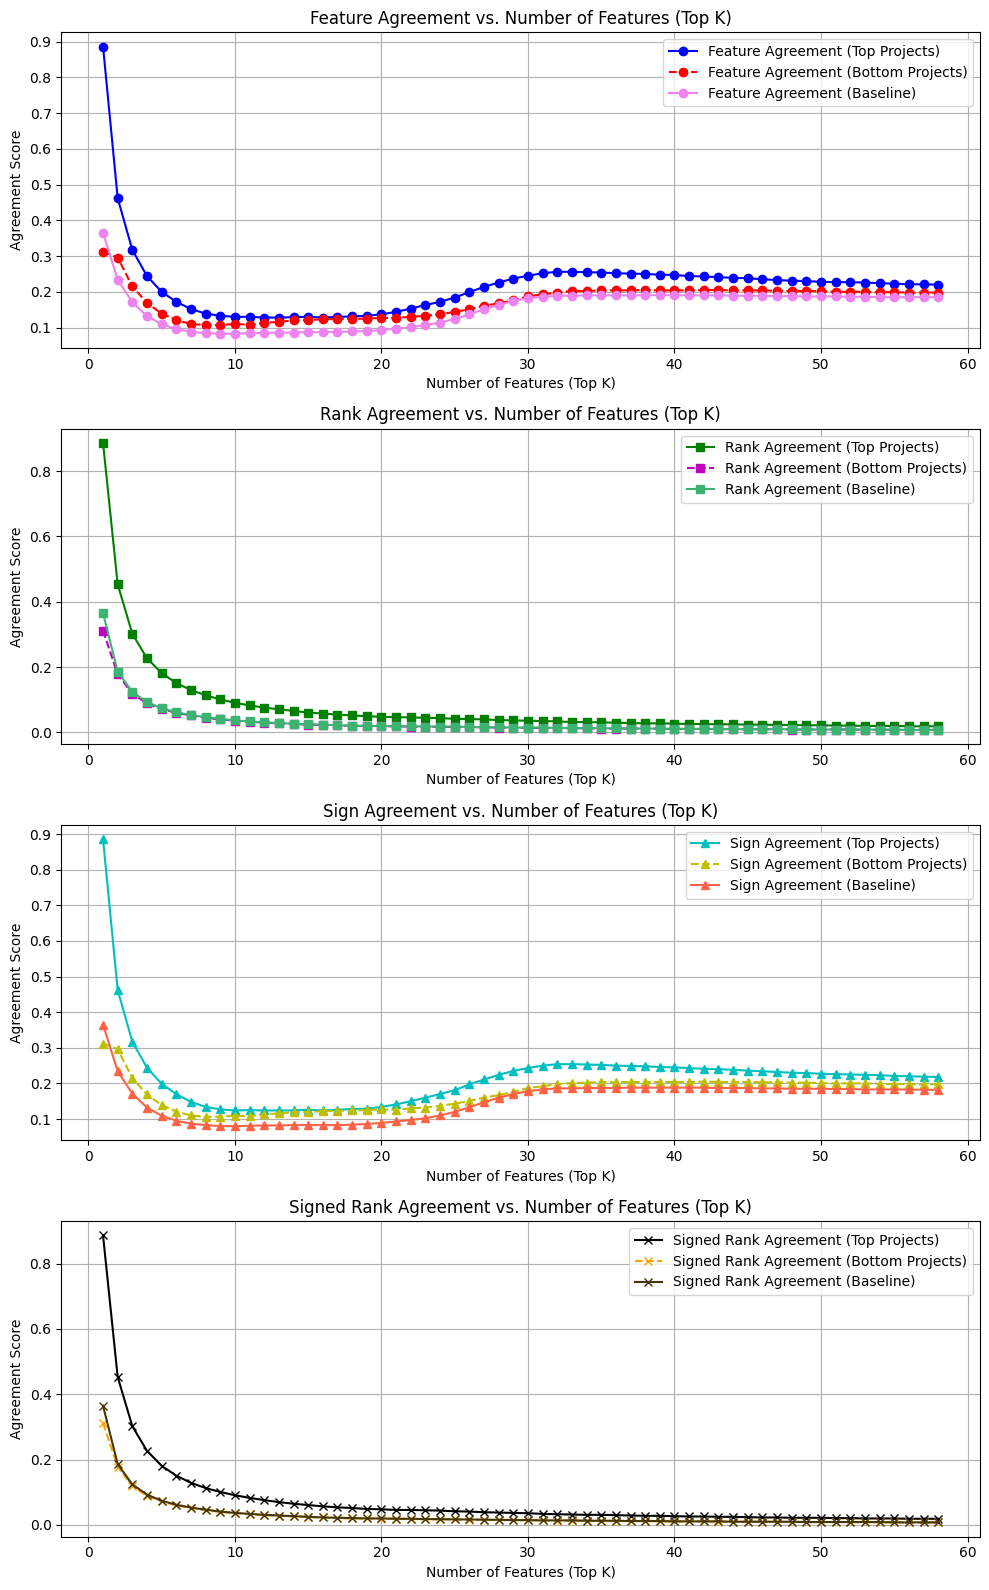

In [23]:
# disagreement_mean_across_top, disagreement_mean_across_bottom, disagreement_mean_across_baseline, feature_n
plot_average_accross_n_projects_various_k_features(mean_top_lvs_non_10 , mean_bottom_lvs_non_10, mean_base_lvs_non_10, 58, "rf_baseline_lvs_top_10%_no_compactor")

All features - Using compactors

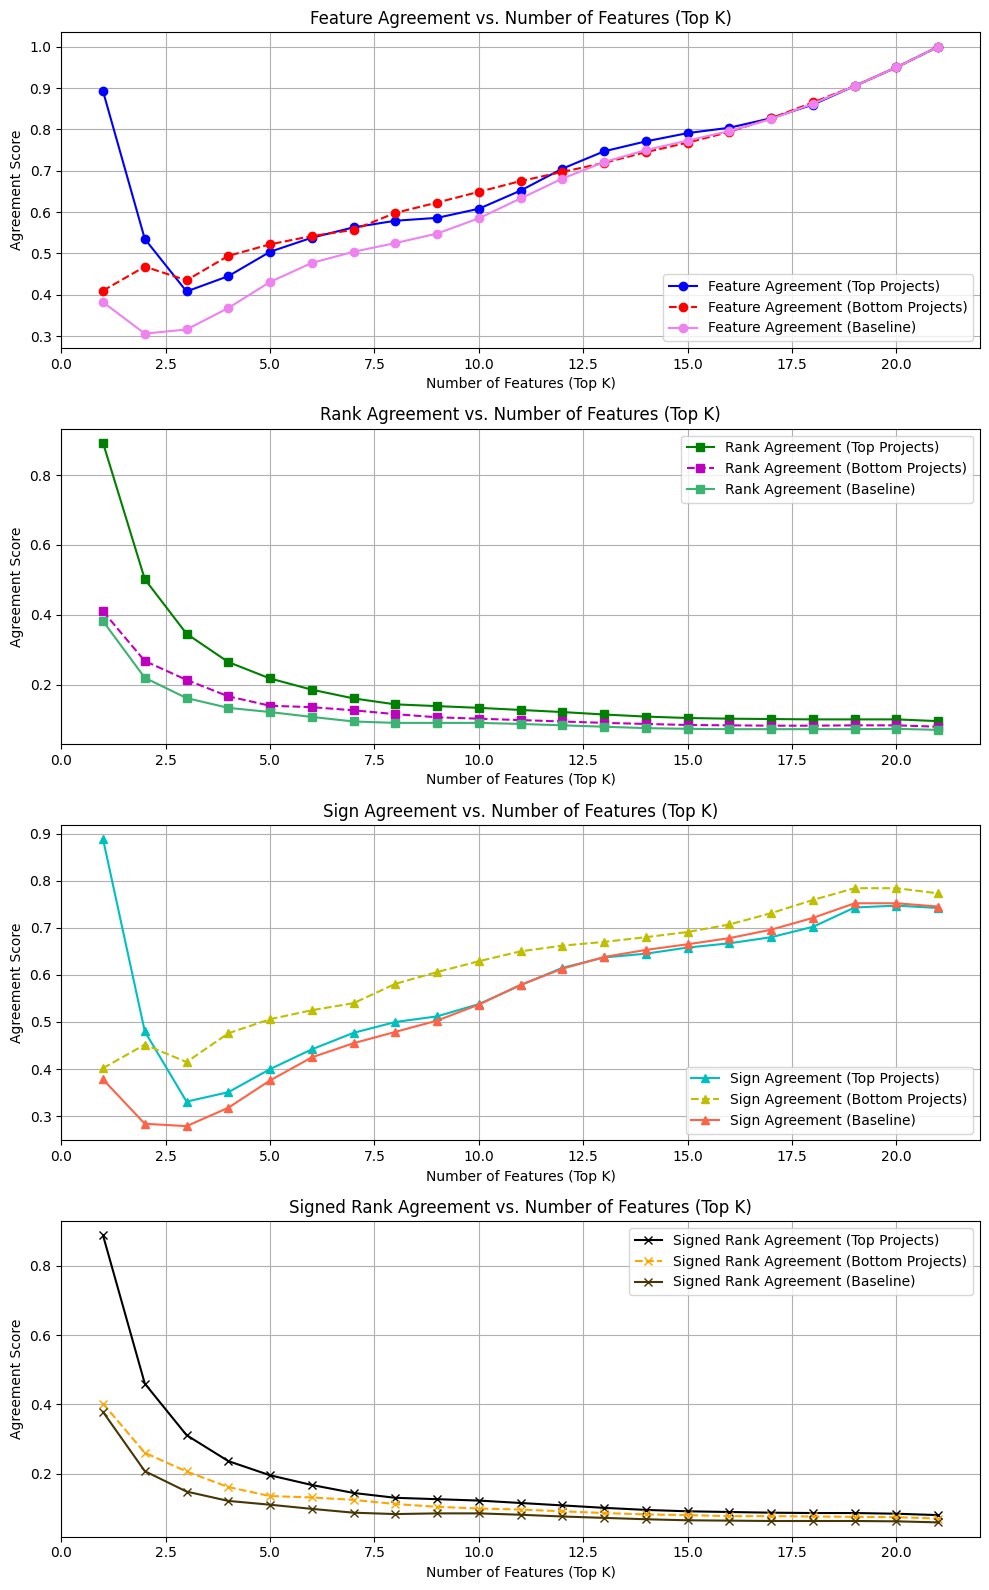

In [25]:
# For max compactor - top 21 features
mean_top_lvs_max , mean_bottom_lvs_max, mean_base_lvs_max = disagreement_for_exp_dict(explanations[fold]['lime'], explanations[fold]['treeshap'], explanations_baseline_combined_exp1, explanations_baseline_combined_exp2, 21, "max", processed)
plot_average_accross_n_projects_various_k_features(mean_top_lvs_max , mean_bottom_lvs_max, mean_base_lvs_max, 21, "rf_baseline_lvs_max_compactor")

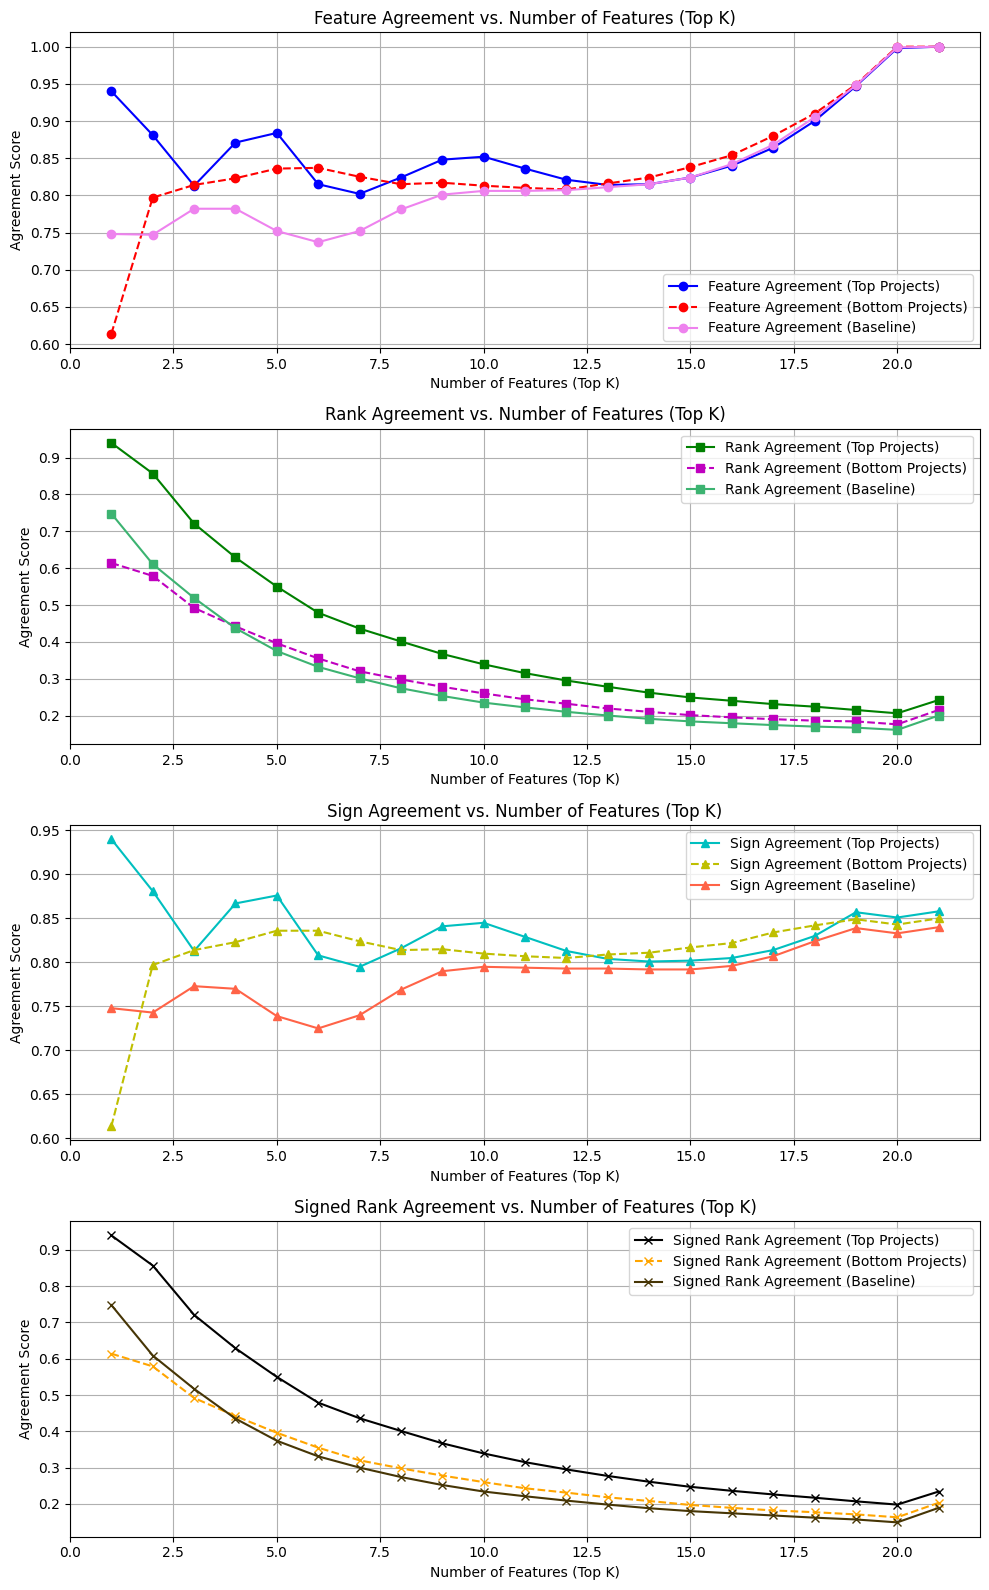

In [14]:
# For activated compactor - top 21 features
mean_top_lvs_act, mean_bottom_lvs_act, mean_base_lvs_act = disagreement_for_exp_dict(explanations[fold]['lime'], explanations[fold]['treeshap'], explanations_baseline_combined_exp1, explanations_baseline_combined_exp2, 21, "activated", processed)
plot_average_accross_n_projects_various_k_features(mean_top_lvs_act , mean_bottom_lvs_act, mean_base_lvs_act, 21, "rf_baseline_lvs_activated_compactor")

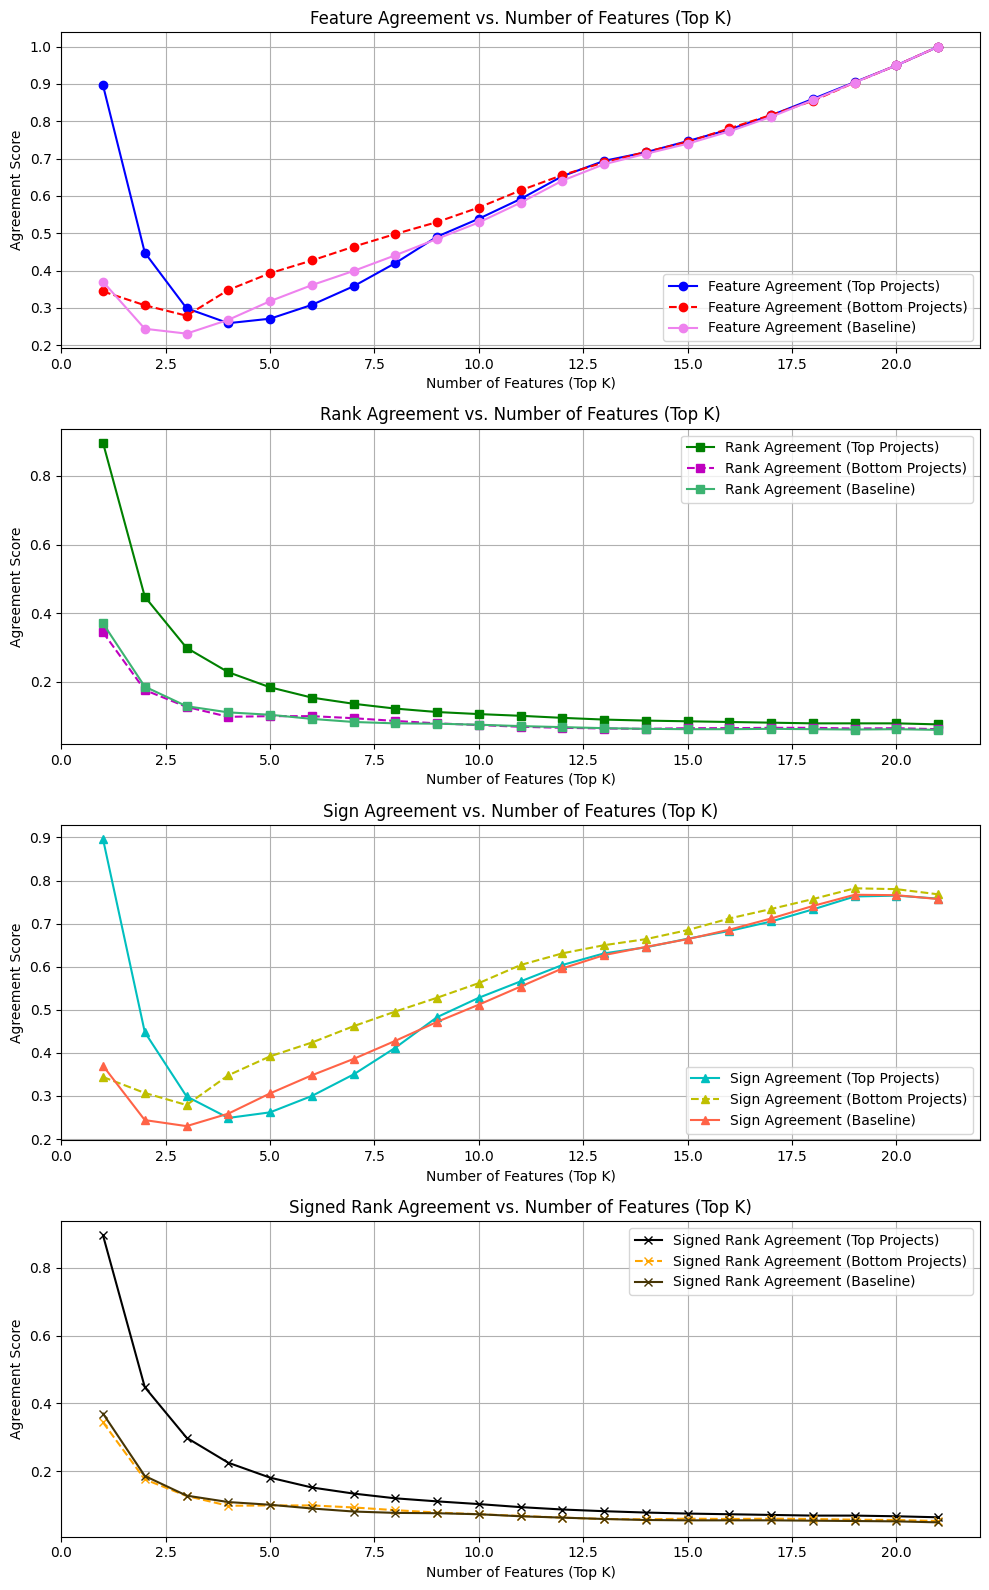

In [15]:
# For max nonactivated compactor - top 21 features
mean_top_lvs_maxnonact, mean_bottom_lvs_maxnonact, mean_base_lvs_maxnonact = disagreement_for_exp_dict(explanations[fold]['lime'], explanations[fold]['treeshap'], explanations_baseline_combined_exp1, explanations_baseline_combined_exp2, 21, "maxnonactivated", processed)
plot_average_accross_n_projects_various_k_features(mean_top_lvs_maxnonact , mean_bottom_lvs_maxnonact, mean_base_lvs_maxnonact, 21, "rf_baseline_lvs_maxnonact_compactor")

2. LIME vs global

In [16]:
# Function to load the pickle file and return the feature importances
def load_model_and_feat(pkl_model_path, model_name):
  # Load the model
  #model = pickle.load(open(pkl_model_path, 'rb'))
  with open(pkl_model_path, "rb") as file_handle:
    model = pickle.load(file_handle)

  if model_name == 'logreg':
    # Load the feature importance array
    importance = model.coef_[0]
  else:
    importance = model.feature_importances_
  # Get the feature names
  feat_names = model.feature_names_in_

  return importance, feat_names


# Function to sort features and output
def sort_features(importance, feat_names):
    # Create df and sort
    df = pd.DataFrame({"Feature": feat_names, "Importance": importance})
    #df_sorted = df.sort_values("Importance", ascending=False)
    df_sorted = df.reindex(df.Importance.abs().sort_values(ascending=False).index)
    return df_sorted

In [17]:
def disagreement_for_global_vs_local(global_exp, local_exp, exp1_baseline, k_range, method=None, raw_data=None):

    # Explanations for top projects
    disagreement_mean_across_top = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_global_vs_local_top = disagreement_average(local_exp['top'], global_exp, False, i, None, raw_data, method)

        for key in list(disagreement_mean_across_top.keys()):
            disagreement_mean_across_top[key].append(explanations_global_vs_local_top[key])

    # Explanations for bottom projects
    disagreement_mean_across_bottom = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_global_vs_local_bottom = disagreement_average(local_exp['bottom'], global_exp, False, i, None, raw_data, method)

        for key in list(disagreement_mean_across_bottom.keys()):
            disagreement_mean_across_bottom[key].append(explanations_global_vs_local_bottom[key])


    # Explanations for baseline projects
    disagreement_mean_across_baseline = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_global_vs_local_baseline = disagreement_average(exp1_baseline, global_exp, False, i, None, raw_data, method)

        for key in list(disagreement_mean_across_baseline.keys()):
            disagreement_mean_across_baseline[key].append(explanations_global_vs_local_baseline[key])

    return disagreement_mean_across_top, disagreement_mean_across_bottom, disagreement_mean_across_baseline


In [45]:
!pip install scikit-learn==1.2.2

In [18]:
# Load the pickle file and get global feature importance
global_importance, feat_names = load_model_and_feat(model_path, "rf")
print(global_importance, feat_names)
global_explanation_feat = sort_features(global_importance, feat_names)
global_explanation_feat.values

[3.61000484e-02 2.59972053e-01 2.38932983e-02 3.65925642e-02
 4.09273999e-02 1.43449148e-02 6.23434576e-02 2.28542013e-03
 9.44354758e-02 6.87659534e-03 5.05636855e-02 1.38445586e-03
 2.51400872e-02 4.76777048e-03 1.88462059e-03 1.62638077e-03
 8.00286977e-04 4.04883136e-04 2.63697138e-04 8.12679251e-04
 5.28259431e-04 4.40797247e-04 6.59705333e-04 0.00000000e+00
 1.06799391e-03 1.03223494e-04 1.45426193e-05 2.26682129e-04
 8.64224050e-05 6.91804929e-05 3.43207484e-04 0.00000000e+00
 6.22417150e-04 4.55330641e-05 0.00000000e+00 4.58919562e-04
 2.35046294e-04 5.28531454e-04 2.30476796e-04 0.00000000e+00
 1.92891789e-03 2.48161773e-04 3.21397865e-05 5.62327971e-04
 1.95860687e-03 1.06183602e-03 1.27164498e-03 0.00000000e+00
 2.13978925e-03 5.83565412e-04 1.48677643e-04 4.47384205e-04
 8.18152591e-04 5.36978820e-04 8.28936721e-04 0.00000000e+00
 1.37420192e-03 3.04535252e-06 1.36462800e-05 4.21279728e-05
 1.11981950e-04 0.00000000e+00 9.99050899e-04 5.53649271e-05
 2.32792537e-04 0.000000

array([['Project Cost', 0.2599720532503212],
       ['School Success Rate', 0.09443547578970575],
       ['School City Success Rate', 0.06234345759559309],
       ...,
       ['Project Subject Subcategory Tree_Financial Literacy, Warmth, Care & Hunger',
        0.0],
       ['Project Subject Subcategory Tree_Foreign Languages, Gym & Fitness',
        0.0],
       ['Project Subject Subcategory Tree_Extracurricular, Nutrition Education',
        0.0]], dtype=object)

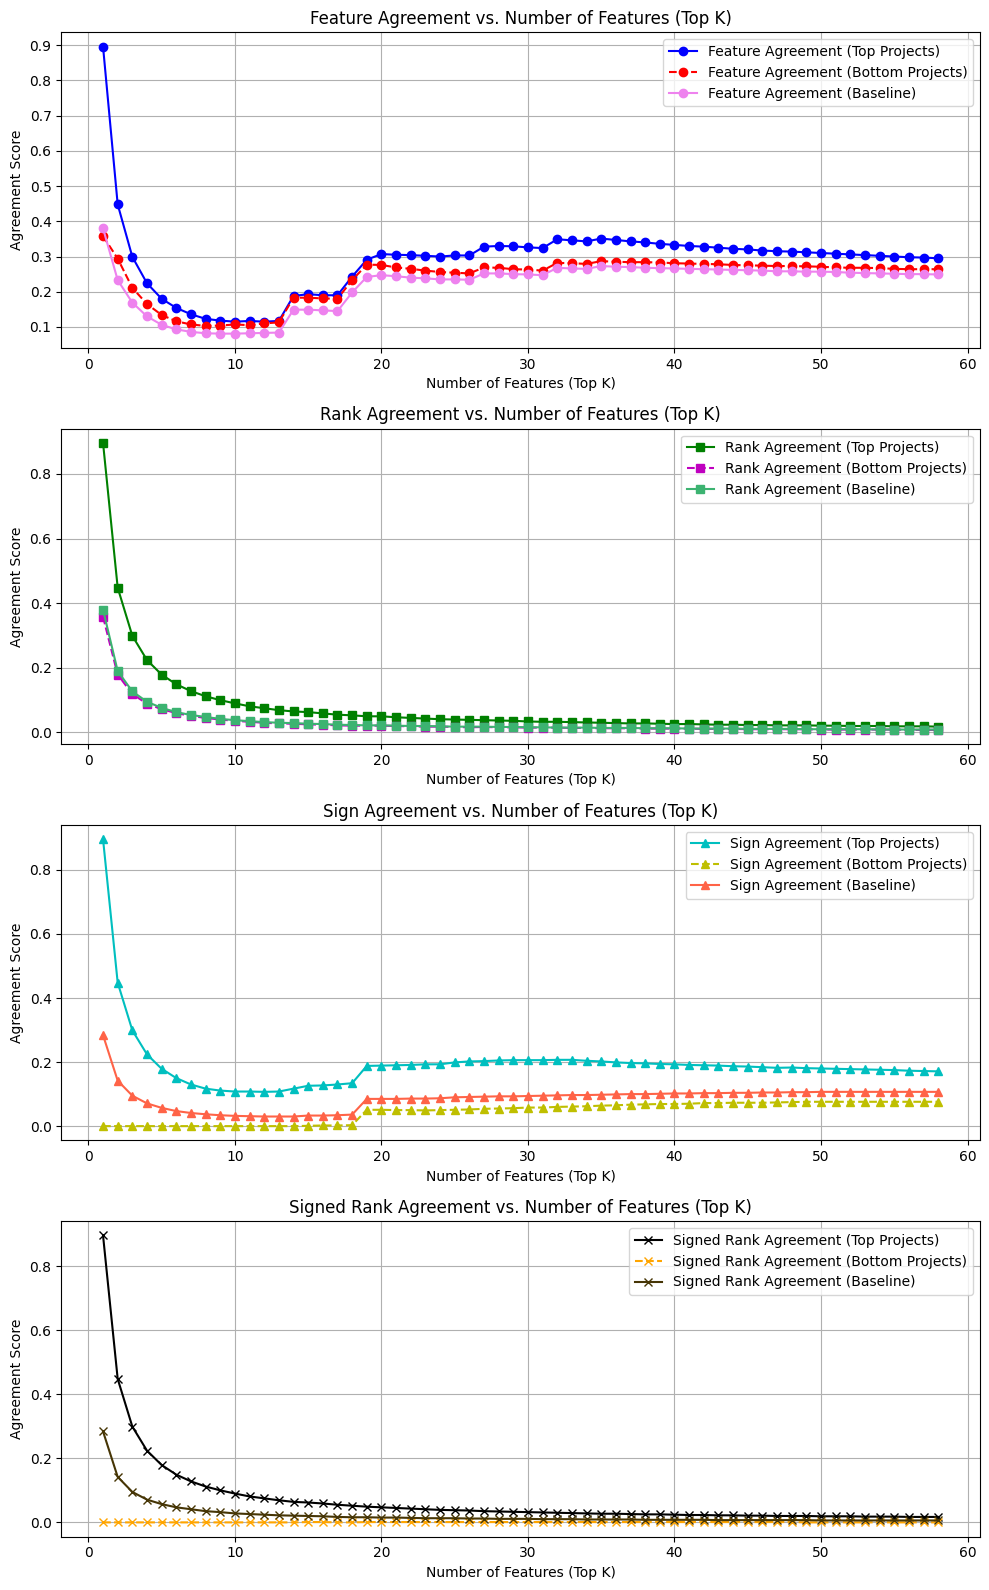

In [19]:
mean_top_lvg_non_10 , mean_bottom_lvg_non_10, mean_base_lvg_non_10 = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['lime'], explanations_baseline_combined_exp1, 58)
plot_average_accross_n_projects_various_k_features(mean_top_lvg_non_10 , mean_bottom_lvg_non_10, mean_base_lvg_non_10, 58, "rf_baseline_lvg_top_10%_no_compactor")

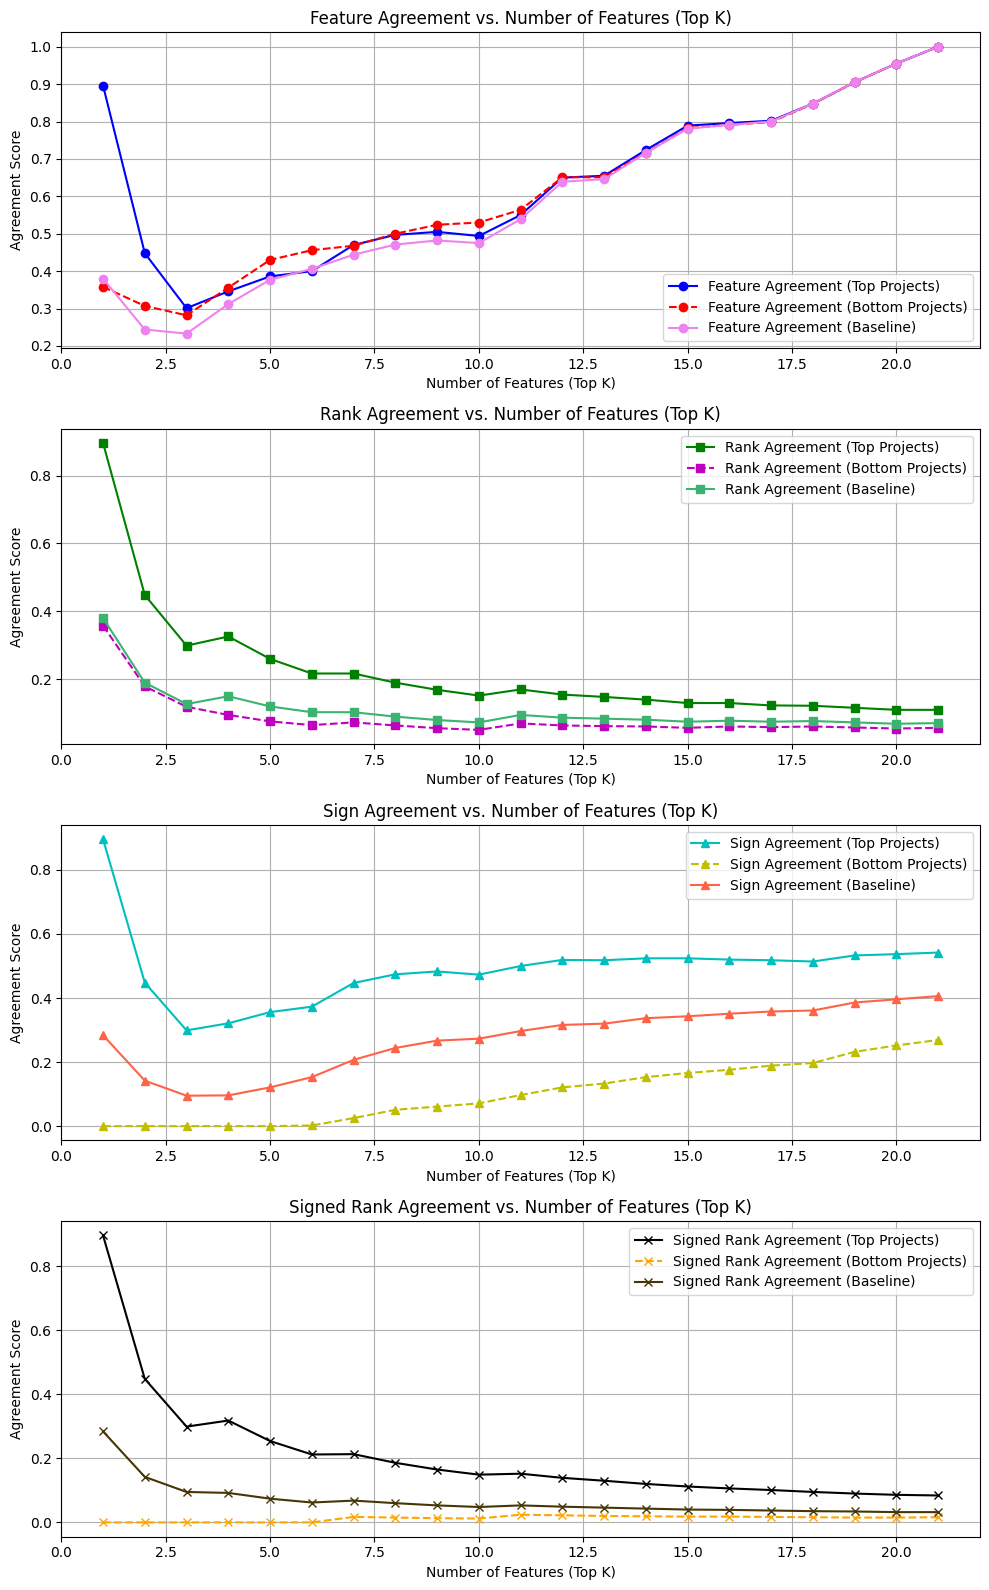

In [20]:
# For max compactor 
mean_top_lvg_max , mean_bottom_lvg_max, mean_base_lvg_max = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['lime'], explanations_baseline_combined_exp1, 21, "max", processed)
plot_average_accross_n_projects_various_k_features(mean_top_lvg_max , mean_bottom_lvg_max, mean_base_lvg_max, 21, "rf_baseline_lvg_max_compactor")

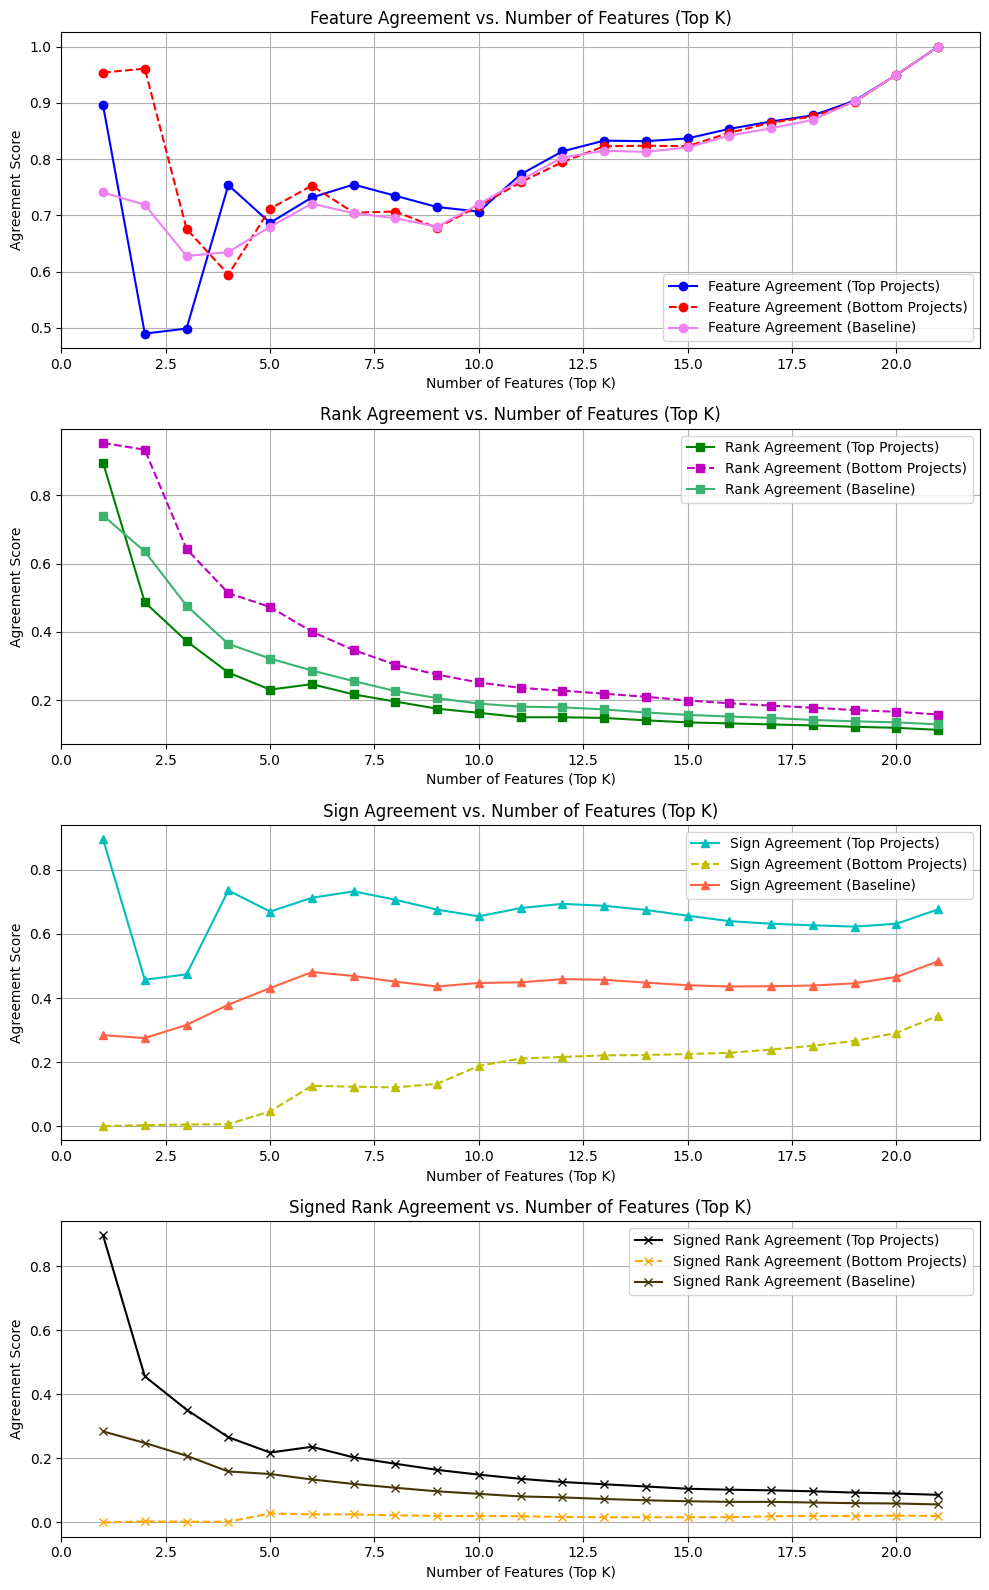

In [21]:
# For activated compactor
mean_top_lvg_act , mean_bottom_lvg_act, mean_base_lvg_act = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['lime'], explanations_baseline_combined_exp1, 21, "activated", processed)
plot_average_accross_n_projects_various_k_features(mean_top_lvg_act , mean_bottom_lvg_act, mean_base_lvg_act, 21, "rf_baseline_lvg_activated_compactor")

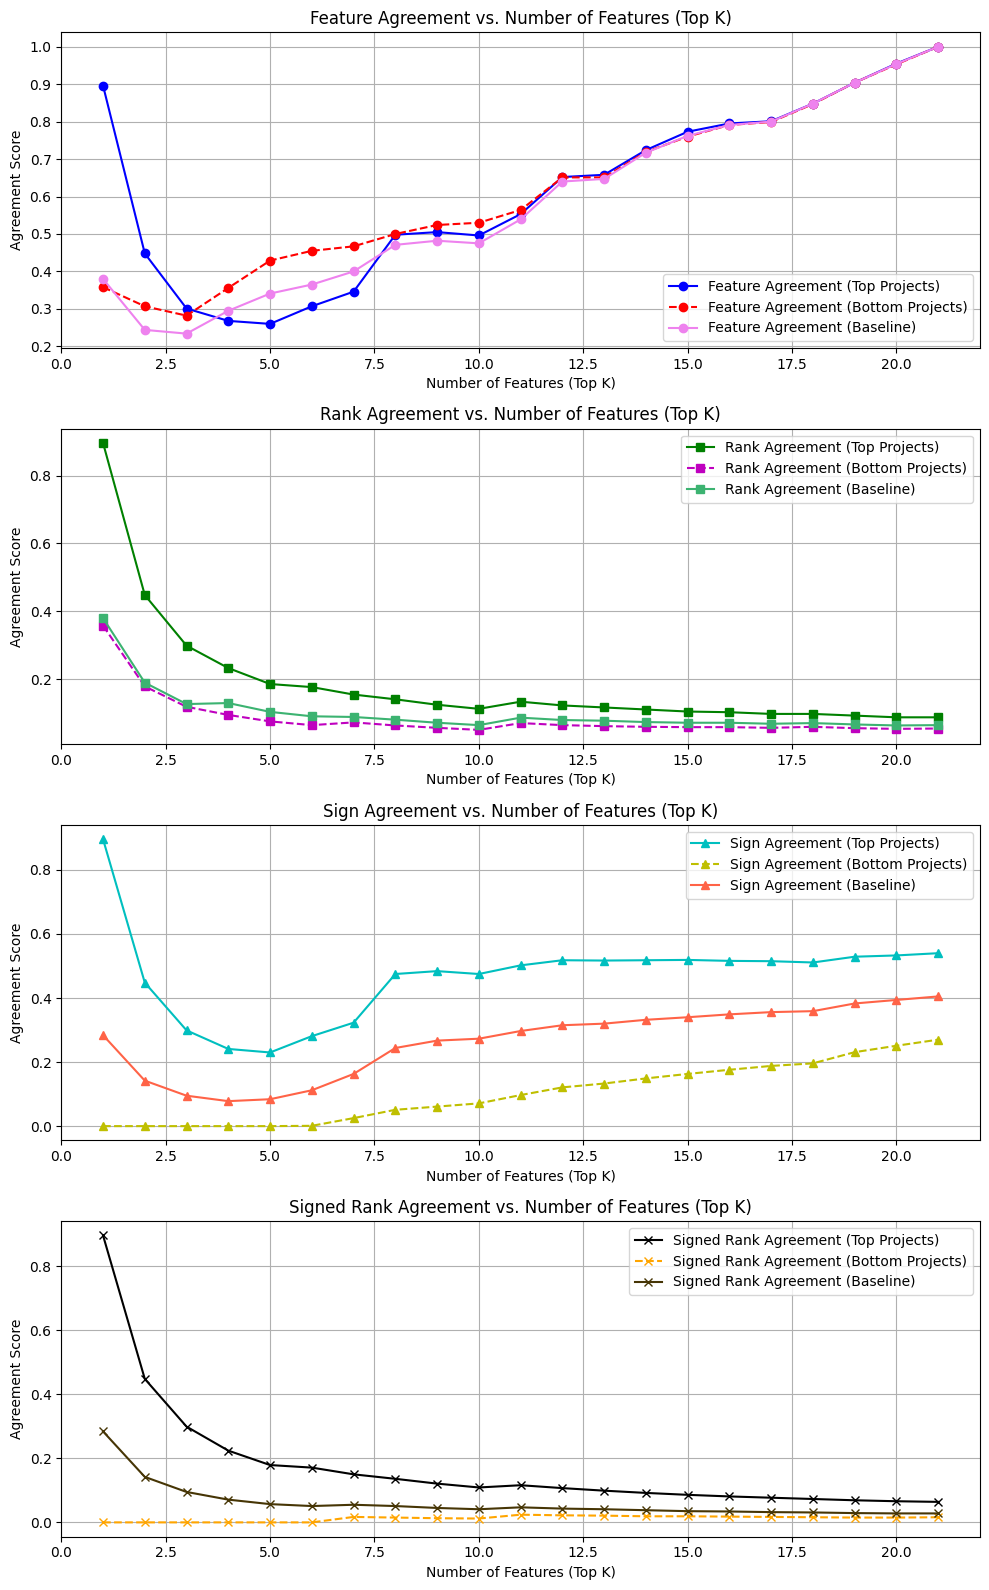

In [22]:
# For max non-activated compactor 
mean_top_lvg_maxnonact , mean_bottom_lvg_maxnonact, mean_base_lvg_maxnonact = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['lime'], explanations_baseline_combined_exp1, 21, "maxnonactivated", processed)
plot_average_accross_n_projects_various_k_features(mean_top_lvg_maxnonact , mean_bottom_lvg_maxnonact, mean_base_lvg_maxnonact, 21, "rf_baseline_lvg_maxnonact_compactor")

3. SHAP vs global

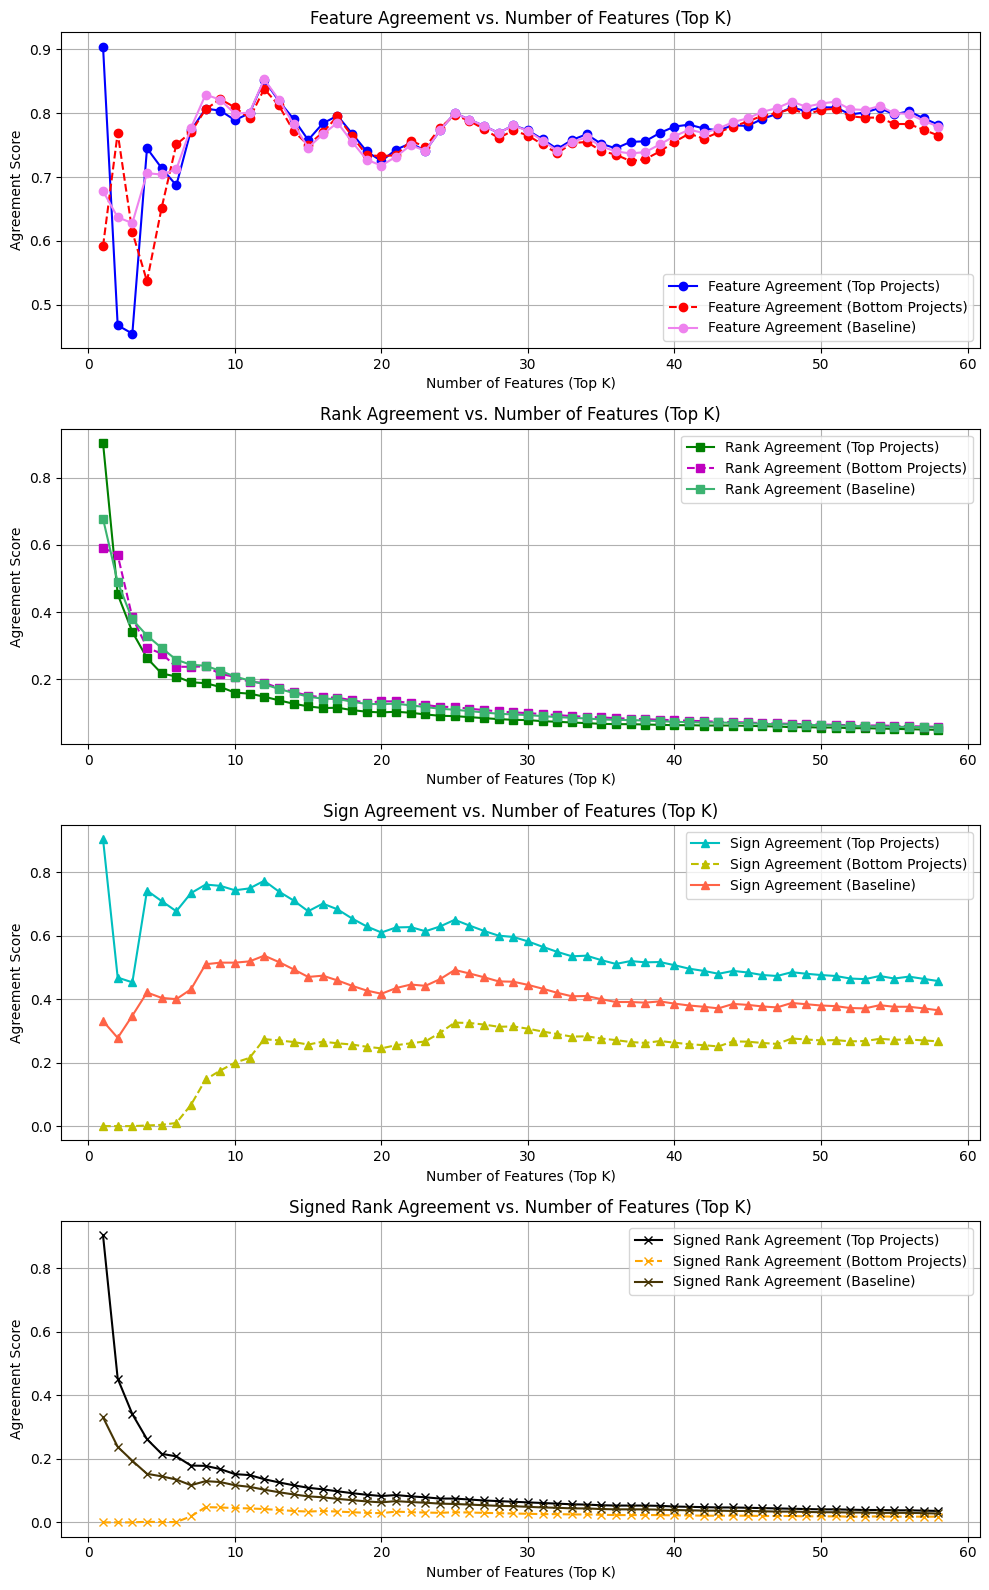

In [23]:
mean_top_svg_non_10 , mean_bottom_svg_non_10, mean_base_svg_non_10 = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['treeshap'], explanations_baseline_combined_exp2, 58)
plot_average_accross_n_projects_various_k_features(mean_top_svg_non_10 , mean_bottom_svg_non_10, mean_base_svg_non_10, 58, "rf_baseline_svg_top_10%_no_compactor")

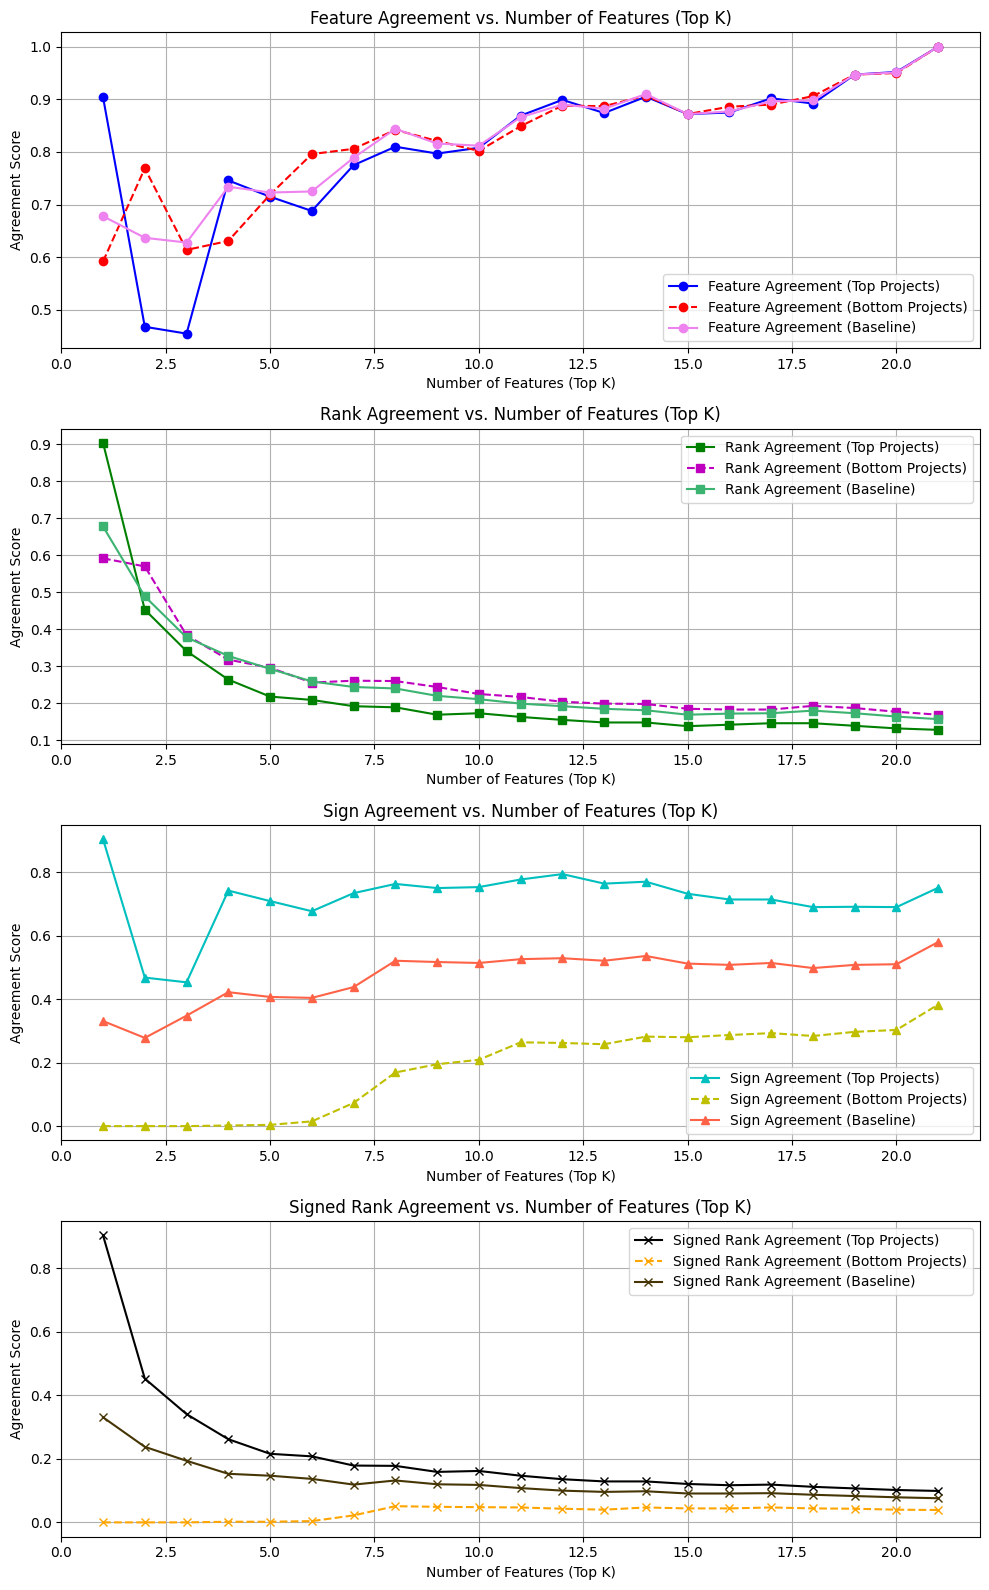

In [24]:
# For max compactor
mean_top_svg_max , mean_bottom_svg_max, mean_base_svg_max = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['treeshap'], explanations_baseline_combined_exp2, 21, "max", processed)
plot_average_accross_n_projects_various_k_features(mean_top_svg_max , mean_bottom_svg_max, mean_base_svg_max, 21, "rf_baseline_svg_max_compactor")

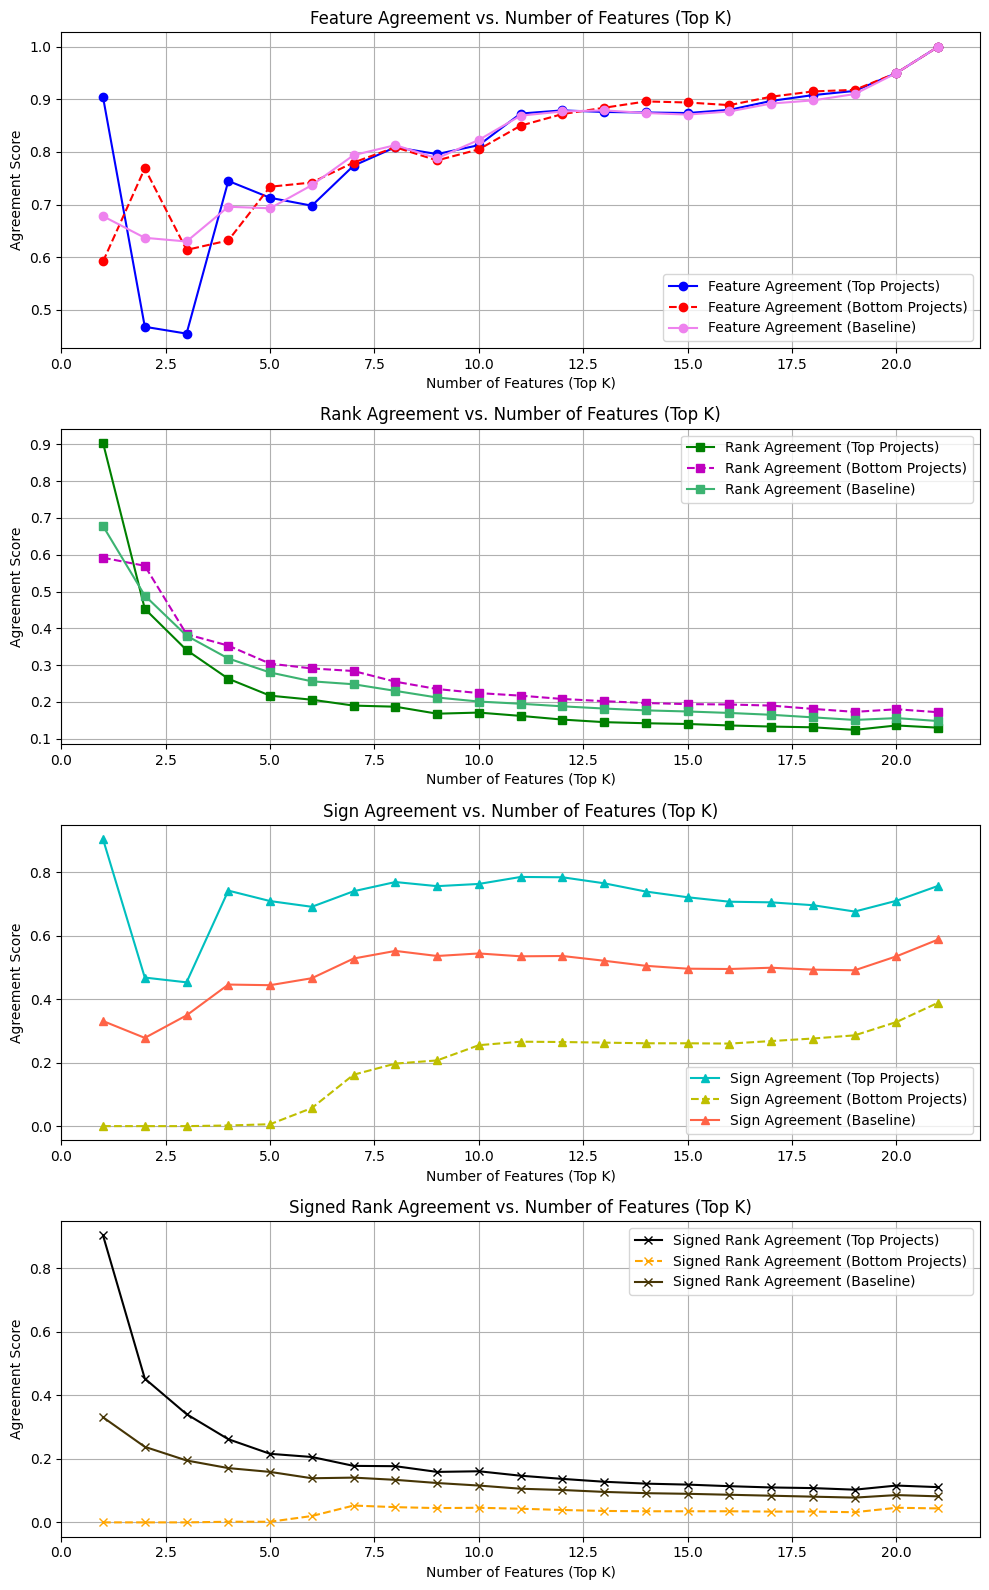

In [25]:
# For activated compactor
mean_top_svg_act , mean_bottom_svg_act, mean_base_svg_act = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['treeshap'], explanations_baseline_combined_exp2, 21, "activated", processed)
plot_average_accross_n_projects_various_k_features(mean_top_svg_act , mean_bottom_svg_act, mean_base_svg_act, 21, "rf_baseline_svg_activated_compactor")

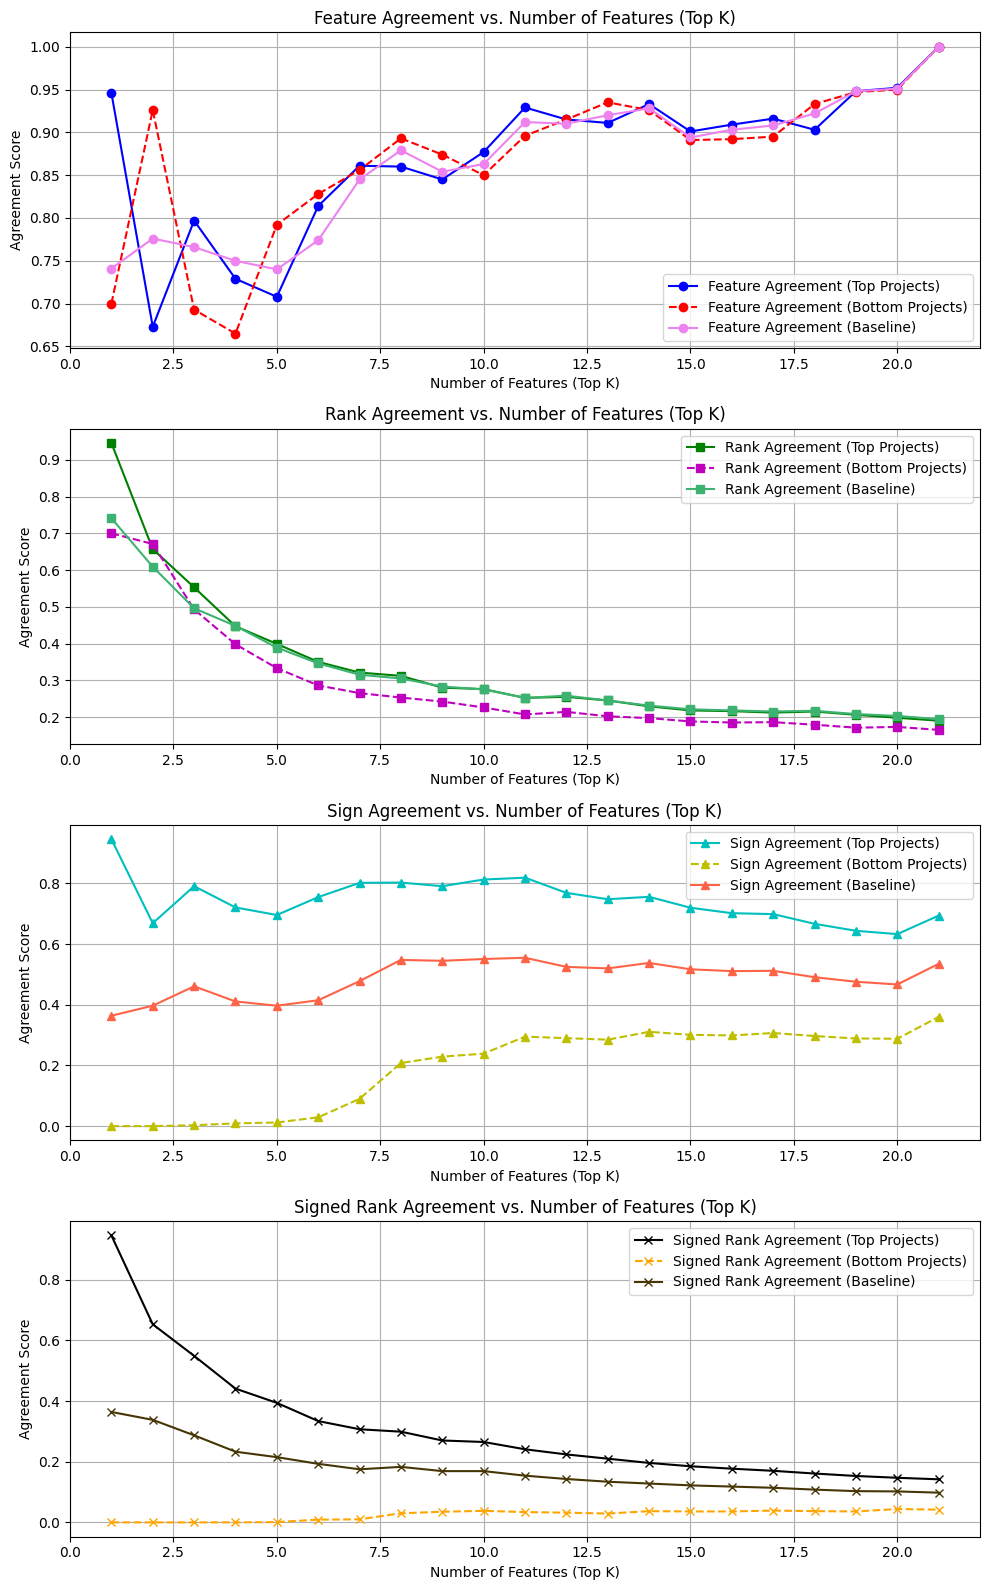

In [26]:
# For max non-activated compactor
mean_top_svg_maxnonact , mean_bottom_svg_maxnonact, mean_base_svg_maxnonact = disagreement_for_global_vs_local(global_explanation_feat.values, explanations[fold]['treeshap'], explanations_baseline_combined_exp2, 21, "maxnonactivated", processed)
plot_average_accross_n_projects_various_k_features(mean_top_svg_maxnonact , mean_bottom_svg_maxnonact, mean_base_svg_maxnonact, 21, "rf_baseline_svg_maxnonact_compactor")